<a href="https://colab.research.google.com/github/FarahMourad/-Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import natsort
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline
from copy import deepcopy
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

# Import my drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
images_path = "/content/gdrive/MyDrive/BSR_dataset/images"
groundTruth_path = "/content/gdrive/MyDrive/BSR_dataset/groundTruth"
kmeans_segmentations_path = "/content/gdrive/MyDrive/BSR_dataset/kmeans_segmentations"

# Data Reading

## Images

In [ ]:
def read_data(path, n = 50):
  pixels = []
  images = []
  for root, dirs, files in os.walk(path):
    files = natsort.natsorted(files)
    for i in range(n):
        # read image and convert it to RGB
        image = cv2.imread(os.path.join(root , files[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
        pixel_vals = image.reshape((-1,3))
        pixel_vals = np.float32(pixel_vals)

        pixels.append(pixel_vals)
        images.append(image)
        
    return images, np.array(pixels)

## Ground Truth

In [ ]:
def read_groundTruth(path, n = 50):
  segmenations = []
  boundaries = []
  for root, dirs, files in os.walk(path):
    files = natsort.natsorted(files)
    for i in range(n):
        mat = scipy.io.loadmat(os.path.join(root , files[i]))
        groundTruth = mat['groundTruth']

        for arr1 in groundTruth:
          img_seg = []
          img_bound = []
          for arr2 in arr1:
            img_bound.append(arr2['Boundaries'][0][0])
            img_seg.append(arr2['Segmentation'][0][0])
          
          segmenations.append(img_seg)
          boundaries.append(img_bound)

  return segmenations, boundaries

## Reading

In [ ]:
images,images_pixels = read_data(images_path)
segmenations, boundaries = read_groundTruth(groundTruth_path)

# Image Visualization

In [ ]:
def show_image(img):
    plt.imshow(img)
    plt.show()

In [ ]:
def show_image_gray(img):
    plt.imshow(img, cmap='gray_r')
    plt.show()

In [ ]:
def show_images_grid(imgs):
  _, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
    ax.imshow(img)
  plt.show()

In [ ]:
def show_image_seg(img, seg):
  _, axs = plt.subplots(1, 2, figsize=(7, 7))
  axs = axs.flatten()
  axs[0].imshow(img)
  axs[1].imshow(seg)
  plt.show()

In [ ]:
def show_images_grid_gray(imgs):
  _, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray_r')
  plt.show()

In [ ]:
def visualize_image(img, segmentations, boundaries,i):
  print("\nImage", i , ":\n")
  show_image(img)

  print("\nSegmentations:\n")
  show_images_grid(segmentations)

  print("\nBoundaries:\n")
  show_images_grid_gray(boundaries)


Image 35 :



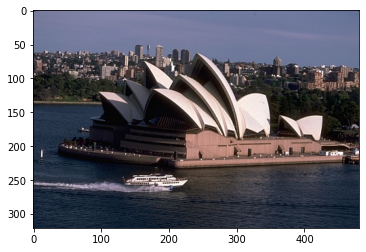


Segmentations:



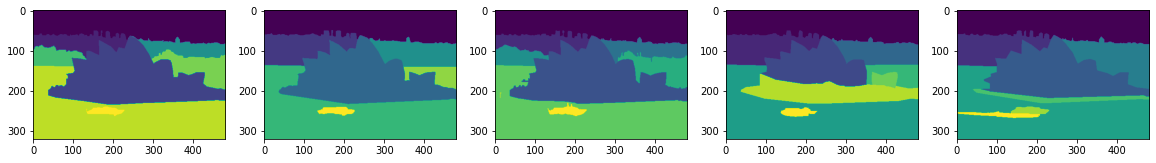


Boundaries:



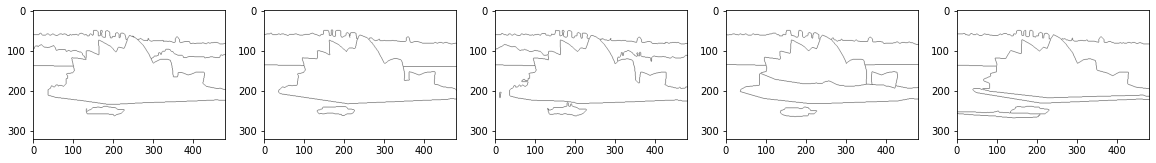

In [ ]:
i = 35

visualize_image(images[i], segmenations[i],boundaries[i],i)

# Evaluation Measures

## F-Measure

In [ ]:
def f_measure(con_matrix, k):
  fi = 0
  for i in range(k):
    prec = max(con_matrix[i]) / np.sum(con_matrix[i])
    rec = max(con_matrix[i]) / np.sum(con_matrix[:,np.argmax(con_matrix[i])])
    fi += (2*prec*rec)/(prec + rec)
  f_measure = fi/k
  return f_measure

## Conditional Entropy

In [ ]:
def cond_entropy(con_matrix, k):
  cond_ent = 0
  mat_sum = np.sum(con_matrix)
  for i in range(k):
    h = 0
    row_sum = np.sum(con_matrix[i])
    for j in range(len(con_matrix[i])):
      p = (con_matrix[i][j] / row_sum)
      if p == 0:
        continue
      h += (-p * np.log2(p))
    cond_ent += h * (row_sum / mat_sum)
  return cond_ent

# KMeans

In [ ]:
def euclidean_distance(p1, p2, xs=1):
    return np.linalg.norm(p1-p2, axis=xs)
def KMeans(img, k):
    centroids = deepcopy(img[:k])
    old_centroids = np.zeros(centroids.shape)
    clusters = np.zeros(len(img))
    difference = euclidean_distance(centroids, old_centroids)
    count = 1
    while (difference.any() and count <= 100):
        for i in range(len(img)):
            distances = euclidean_distance(img[i], centroids)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        old_centroids = deepcopy(centroids)
        for i in range(k):
          ps = [] 
          for j in range(len(img)):
            if (clusters[j] == i):
              ps.append(img[j]) 
          if(len(ps) != 0):
              centroids[i] = np.mean(ps, axis=0)  
        difference = euclidean_distance(centroids, old_centroids)
        count += 1
    clusters = np.array(clusters, dtype=np.int16)
    return centroids, clusters

In [ ]:
def save_img(image, k, indx):
  plt.imsave( kmeans_segmentations_path + "/" + str(k) + "/image_" + str(indx) + ".jpg", image)

In [ ]:
#k = [3, 5, 7, 9, 11]
k = 3
fscore_avg = []
entropy_avg = []
segmented_images = []
for i in range(50):
  centers, labels = KMeans(images_pixels[i], k)
  centers = np.uint8(centers)
  segmented_image = labels.reshape(images[i].shape[:2])
  segmented_images.append(segmented_image)
  save_img(segmented_image,k,i)
  f_score = []
  entropy = []
  for seg in segmenations[i]:
    cont_mat = np.transpose(contingency_matrix(seg.flatten(), labels))
    f_score.append(round(f_measure(cont_mat, k),5))
    entropy.append(round(cond_entropy(cont_mat, k),5))

  print()
  print("\nImage", i ,"Evaluation\n")
  fscore_avg.append(round(sum(f_score)/len(f_score), 5))
  print("F-Score: ", f_score , ",avg = ", round(sum(f_score)/len(f_score), 5))
  entropy_avg.append(round(sum(entropy)/len(entropy), 5))
  print("Conditional Entropy: ", entropy , ",avg = ", round(sum(entropy)/len(entropy), 5))



Image 0 Evaluation

F-Score:  [0.52183, 0.5218, 0.56257, 0.55525, 0.44999] ,avg =  0.52229
Conditional Entropy:  [2.1728, 1.89767, 1.55927, 1.52199, 2.05005] ,avg =  1.84036


Image 1 Evaluation

F-Score:  [0.75955, 0.75977, 0.76109, 0.75935, 0.67854, 0.75676] ,avg =  0.74584
Conditional Entropy:  [0.0979, 0.09585, 0.08985, 0.12814, 1.94257, 0.15369] ,avg =  0.418


K=  3
F-Score for dataset:  [0.52229, 0.74584] ,avg =  0.63406
Conditional Entropy for dataset:  [1.84036, 0.418] ,avg =  1.12918

Bad Results: 

Image 0


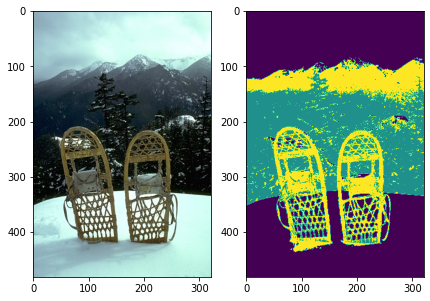

Average fscore = 0.52229 ,Average Entropy = 1.84036


Good Results: 

Image 1


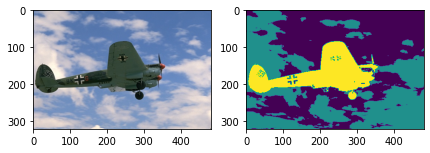

Average fscore = 0.74584 ,Average Entropy = 0.418



In [ ]:
n = 5

print("K= ",k)
print("F-Score for dataset: ", fscore_avg , ",avg = ", round(sum(fscore_avg)/len(fscore_avg), 5))
print("Conditional Entropy for dataset: ", entropy_avg , ",avg = ", round(sum(entropy_avg)/len(entropy_avg), 5))
fscore_ind = np.argsort(fscore_avg)
entropy_ind = np.argsort(entropy_avg)

bad_ind = fscore_ind[:n]
good_ind = fscore_ind[-n:]

print("\nBad Results: \n")
for i in bad_ind:
  print("Image",i)
  show_image_seg(images[i],segmented_images[i])
  print("Average fscore =",fscore_avg[i], ",Average Entropy =",entropy_avg[i] )
  print()

print("\nGood Results: \n")
for i in good_ind:
  print("Image",i)
  show_image_seg(images[i],segmented_images[i])
  print("Average fscore =",fscore_avg[i], ",Average Entropy =",entropy_avg[i] )
  print()

# Big Picture

## K-means at k = 5

In [ ]:
k = 5
i = 2
_, labels = KMeans(images_pixels[i], k)


Image:



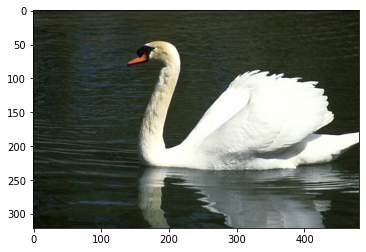


Ground Truth:



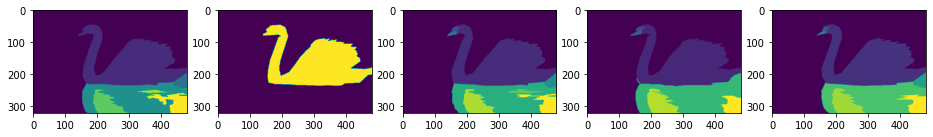


Segmented Image:



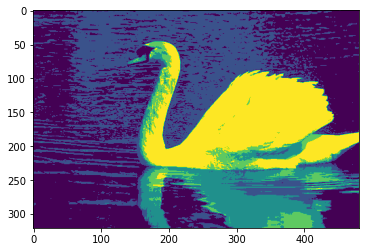



Image 4 Evaluation

F-Score:  [0.612, 0.491, 0.612, 0.604, 0.613] ,avg =  0.586
Conditional Entropy:  [0.741, 0.208, 0.745, 0.714, 0.696] ,avg =  0.621


In [ ]:
segmented_image = labels.reshape(images[i].shape[:2])

print("\nImage:\n")
show_image(images[i])

print("\nGround Truth:\n")
show_images_grid(segmenations[i])

print("\nSegmented Image:\n")
show_image(segmented_image)


f_score = []
entropy = []
for seg in segmenations[i]:
   cont_mat = np.transpose(contingency_matrix(seg.flatten(), labels))
   f_score.append(round(f_measure(cont_mat, 5),3))
   entropy.append(round(cond_entropy(cont_mat, 5),3))

print()
print("\nImage", i ,"Evaluation\n")
print("F-Score: ", f_score , ",avg = ", round(sum(f_score)/len(f_score), 3))
print("Conditional Entropy: ", entropy , ",avg = ", round(sum(entropy)/len(entropy), 3))

## Normalized-cut for the 5-NN graph, at K=5.

Image:


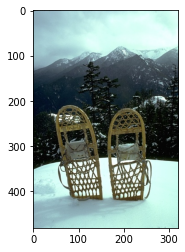

Ground Truth:


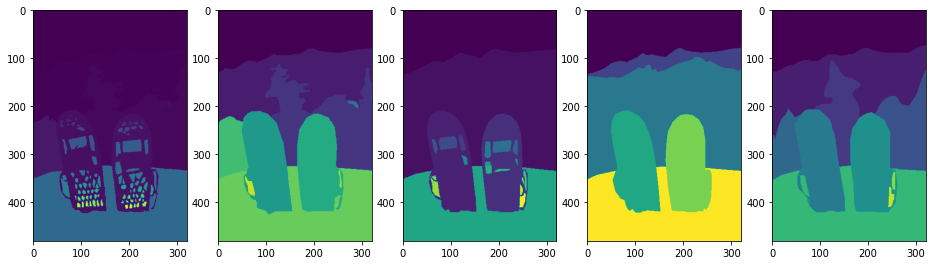

Normalized cut:


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
i = 0
clusters = SpectralClustering(n_clusters=5,affinity='nearest_neighbors',n_neighbors=5,random_state=1).fit(images_pixels[i])


Image:



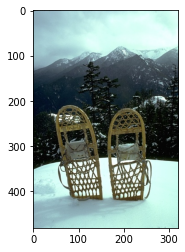


Ground Truth:



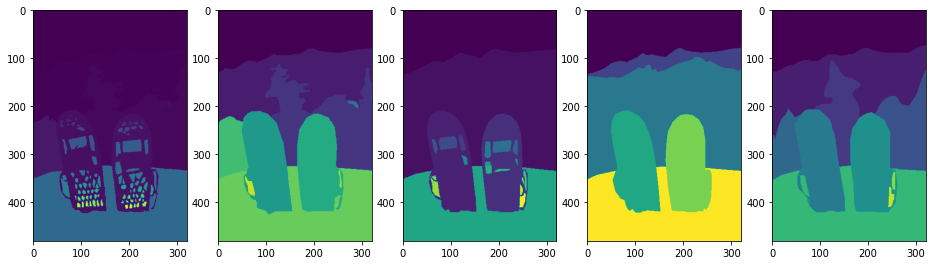


Segmented Image:



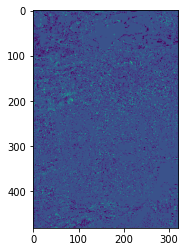



Image 0 Evaluation

F-Score:  [0.141, 0.141, 0.173, 0.162, 0.14] ,avg =  0.151
Conditional Entropy:  [3.053, 2.693, 2.338, 2.361, 2.825] ,avg =  2.654


In [ ]:

segmented_image = clusters.labels_.reshape(images[i].shape[:2])

print("\nImage:\n")
show_image(images[i])

print("\nGround Truth:\n")
show_images_grid(segmenations[i])

print("\nSegmented Image:\n")
show_image(segmented_image)


f_score = []
entropy = []
for seg in segmenations[i]:
   cont_mat = np.transpose(contingency_matrix(seg.flatten(), clusters.labels_))
   f_score.append(round(f_measure(cont_mat, 5),3))
   entropy.append(round(cond_entropy(cont_mat, 5),3))

print()
print("\nImage", i ,"Evaluation\n")
print("F-Score: ", f_score , ",avg = ", round(sum(f_score)/len(f_score), 3))
print("Conditional Entropy: ", entropy , ",avg = ", round(sum(entropy)/len(entropy), 3))

# Spatial Layout Encoding


In [ ]:
def encode_spatial_layout(images):
  pixels = []
  trans = MinMaxScaler()
  for img in images:
    indices = np.indices(img.shape[:2])
    data = np.dstack((img, indices[0], indices[1])).reshape(-1,5)
    data = trans.fit_transform(data)
    pixels.append(data)
  return pixels

In [ ]:
images_pixels_s = encode_spatial_layout(images)

print(images_pixels_s[0].shape)
print(images_pixels_s[0])

(154401, 5)
[[0.10196078 0.13333333 0.09019608 0.         0.        ]
 [0.09411765 0.1254902  0.08235294 0.         0.003125  ]
 [0.08627451 0.1254902  0.09411765 0.         0.00625   ]
 ...
 [0.70980392 0.91764706 0.87843137 1.         0.99375   ]
 [0.70196078 0.90980392 0.87058824 1.         0.996875  ]
 [0.70588235 0.90588235 0.87058824 1.         1.        ]]


In [ ]:
k = 5
i = 4
_, labels = KMeans(images_pixels_s[i], k)


Image:



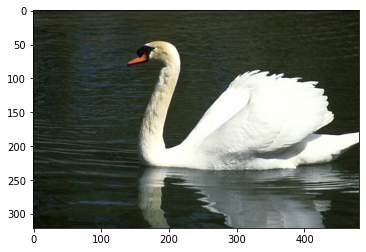


Ground Truth:



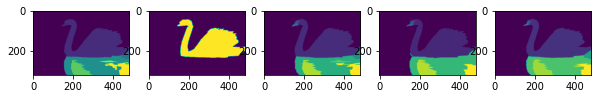


Segmented Image:



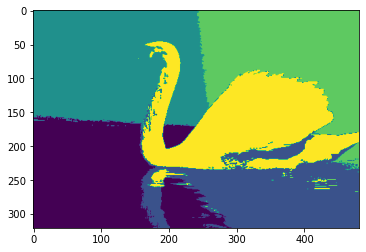



Image 4 Evaluation

F-Score:  [0.63, 0.495, 0.633, 0.64, 0.641] ,avg =  0.608
Conditional Entropy:  [0.558, 0.22, 0.569, 0.518, 0.514] ,avg =  0.476


In [ ]:
segmented_image = labels.reshape(images[i].shape[:2])

print("\nImage:\n")
show_image(images[i])

print("\nGround Truth:\n")
show_images_grid(segmenations[i])

print("\nSegmented Image:\n")
show_image(segmented_image)


f_score = []
entropy = []
for seg in segmenations[i]:
   cont_mat = np.transpose(contingency_matrix(seg.flatten(), labels))
   f_score.append(round(f_measure(cont_mat, 5),3))
   entropy.append(round(cond_entropy(cont_mat, 5),3))

print()
print("\nImage", i ,"Evaluation\n")
print("F-Score: ", f_score , ",avg = ", round(sum(f_score)/len(f_score), 3))
print("Conditional Entropy: ", entropy , ",avg = ", round(sum(entropy)/len(entropy), 3))